# Grille équilibre - diversification

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from classes import Grid

## 1. Récupération des données sur les indices et calcul des rendements

On récupère l'historique des indices composant le portefeuille du 5 janvier 2015 au 17 février 2025 (historique de 10 ans). Il se peut, pour diverses raisons, que des valeurs soient manquantes dans certains indices. Comme celles-ci demeurent rares, on remplace les valeurs manquantes par interpolation. 

In [2]:
sheet_valeurs_indices = pd.read_excel("Données.xlsx", sheet_name="Valeurs indices")

In [3]:
valeurs_indices = sheet_valeurs_indices.iloc[2:, :]
valeurs_indices.columns = ["Date", *sheet_valeurs_indices.iloc[1,1:].values]
valeurs_indices.set_index("Date", inplace=True)
valeurs_indices = valeurs_indices.astype(float)
display(valeurs_indices.head(3))

,MSDEE15N Index,MCLDE15 Index,MLCLEEU Index,MIVLACE Index,MGILAWO Index,MGILACE Index,MIVLAWO Index,SPX Index,NKY Index,HSI Index,...,LF98TRUU Index,LMBITR Index,EMLCTRUU Index,LEGATRUU Index,BTSYTRUU Index,OISESTR Index,SPBDELB Index,NU739027 Index,B3REITP Index,DE732829 Index
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,172.2761,323.068,717.976,700.933,1217.545,1002.001,948.224,2020.58,17408.71,23721.32,...,1616.78,1073.1775,124.5390,455.6390,571.1771,101.445541,96.4339,1088.4707,976.62,1148.2003
2015-01-06,171.1073,320.584,728.120,697.622,1203.919,995.805,939.415,2002.61,16883.19,23485.41,...,1611.06,1076.4537,125.2347,457.3734,574.3066,101.445329,96.4037,1077.9359,985.54,1137.5853
2015-01-07,171.9515,320.593,729.859,700.915,1214.489,998.363,945.793,2025.90,16885.33,23681.26,...,1615.91,1076.6788,125.1037,455.1824,570.8374,101.445115,96.3670,1082.6237,1000.10,1153.6238


On identifie les colonnes qui présentent des valeurs nulles

In [4]:
null_values = [(col, val) for col, val in zip((valeurs_indices.isnull().sum() / len(valeurs_indices)).index, 
                                              (valeurs_indices.isnull().sum() / len(valeurs_indices)).values) 
               if val != 0]
display(null_values)

[('SPX Index', 0.025193798449612403),
 ('NKY Index', 0.060077519379844964),
 ('HSI Index', 0.04263565891472868),
 ('CAC Index', 0.0050387596899224806),
 ('VANEUIG Index', 0.001937984496124031),
 ('LBUSTRUU Index', 0.024806201550387597),
 ('LF98TRUU Index', 0.024806201550387597),
 ('LMBITR Index', 0.02131782945736434),
 ('SPBDELB Index', 0.0007751937984496124),
 ('B3REITP Index', 0.013565891472868217)]

On a au maximum 6% de valeurs manquantes pour le Nikkei. Le remplacement des valeurs nulles par interpolation entre les valeurs non nulles les plus proches n'est pas aberrantes.

In [5]:
cols_with_na = [col for col in valeurs_indices.columns if valeurs_indices[col].isnull().sum() != 0]
valeurs_indices[cols_with_na] = valeurs_indices[cols_with_na].interpolate(method = 'linear')
print(f"Le nombre de valeurs nulles dans le dataframe 'valeurs_indices' est de {valeurs_indices.isnull().sum().sum()}")

Le nombre de valeurs nulles dans le dataframe 'valeurs_indices' est de 0


On calcule maintenant les rendements journaliers

In [6]:
nb_rows = valeurs_indices.shape[0]
daily_returns = (valeurs_indices.iloc[1:nb_rows, :].values /
                 valeurs_indices.iloc[:nb_rows-1, :].values) - 1
daily_returns = pd.DataFrame(daily_returns, 
                             index=valeurs_indices.index[1:nb_rows],  
                             columns=valeurs_indices.columns) 
print(f"Le nombre de valeurs nulles dans le dataframe 'daily_returns' est de {daily_returns.isnull().sum().sum()}")


Le nombre de valeurs nulles dans le dataframe 'daily_returns' est de 0


In [7]:
# A modifier si on ajoute / supprime des indices
cols_equity = daily_returns.columns[0:11]
cols_bonds = daily_returns.columns[11:20]
cols_cash = daily_returns.columns[20]
cols_alternatives = daily_returns.columns[21:]

On calcule les rendements annuels "totaux", mais on calcule les rendements mensuels et trimestriels sur fenêtre glissante. Dans un mois, environ 21 jours ouvrés ; dans un trimestre, environ 63 jours ouvrés.

In [8]:
monthly_returns = (valeurs_indices / valeurs_indices.shift(21) - 1).dropna()  
quarterly_returns = (valeurs_indices / valeurs_indices.shift(63) - 1).dropna()  
annual_returns = (valeurs_indices.resample('YE').last().pct_change()).dropna()

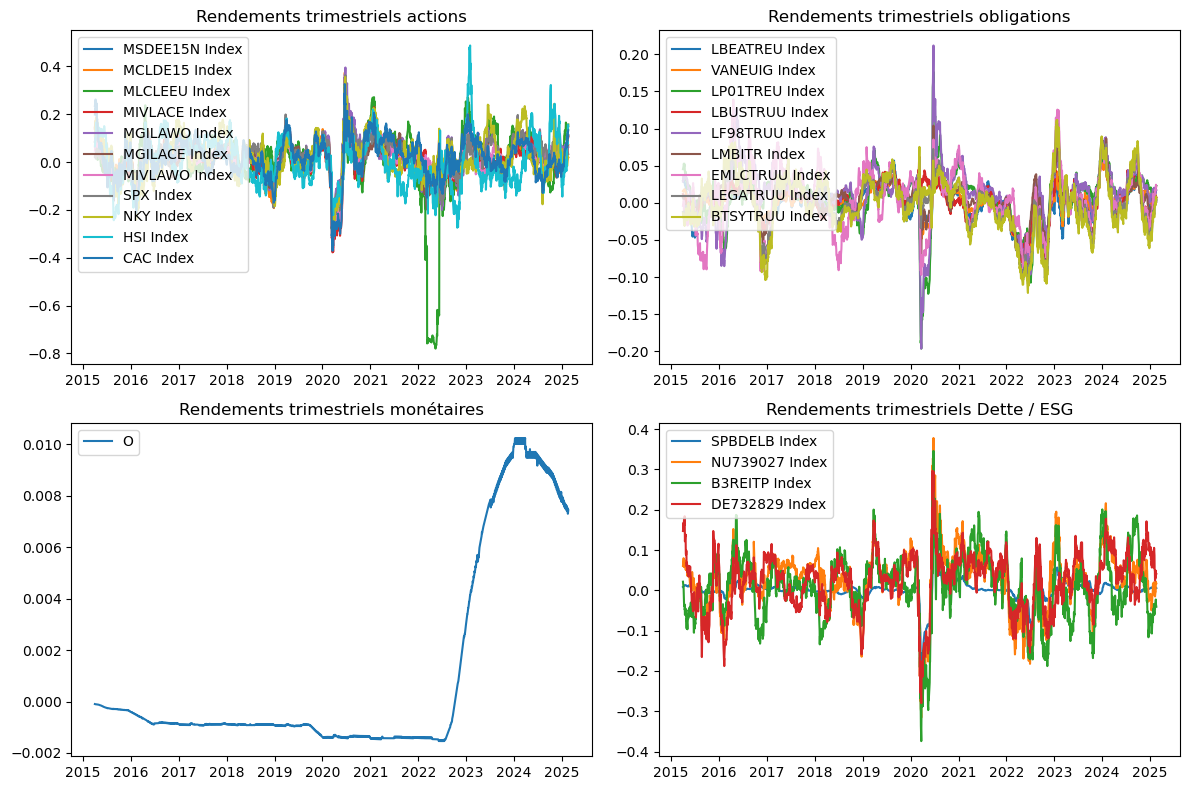

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Création de la figure et des sous-graphiques

# Tracé des rendements actions
axes[0, 0].plot(quarterly_returns[cols_equity])
axes[0, 0].set_title("Rendements trimestriels actions")
axes[0, 0].legend(cols_equity, loc='upper left')  # Ajouter une légende

# Tracé des rendements obligations
axes[0, 1].plot(quarterly_returns[cols_bonds])
axes[0, 1].set_title("Rendements trimestriels obligations")
axes[0, 1].legend(cols_bonds, loc='upper left')

# Tracé des rendements monétaires
axes[1, 0].plot(quarterly_returns[cols_cash])
axes[1, 0].set_title("Rendements trimestriels monétaires")
axes[1, 0].legend(cols_cash, loc='upper left')

# Tracé des rendements dette / ESG
axes[1, 1].plot(quarterly_returns[cols_alternatives])
axes[1, 1].set_title("Rendements trimestriels Dette / ESG")
axes[1, 1].legend(cols_alternatives, loc='upper left')

# Ajustement automatique de l'espacement entre les graphiques
plt.tight_layout()

plt.show()

## 2. Grille initiale

In [10]:
sheet_weights = pd.read_excel("Données.xlsx", sheet_name="Grille équilibre initiale") 
initial_weights = sheet_weights.iloc[1:,:].astype(float)
initial_weights = initial_weights.set_index("Horizon")
hypothetical_returns = pd.DataFrame(np.tile([0.06, 0.035, 0.02], (41, 1)), columns=["Actions", "Obligations", "Monétaire"])
initial_grid = Grid(initial_weights, hypothetical_returns, quarterly_returns[["MSDEE15N Index", "LBEATREU Index", "OISESTR Index"]], annalization_factor=4)

On affiche l'évolution des parts, de la volatilité, du rendement, et les corrélation entre les rendements

<Axes: title={'center': 'Matrice de corrélation des rendements historiques'}>

<Figure size 1200x600 with 0 Axes>

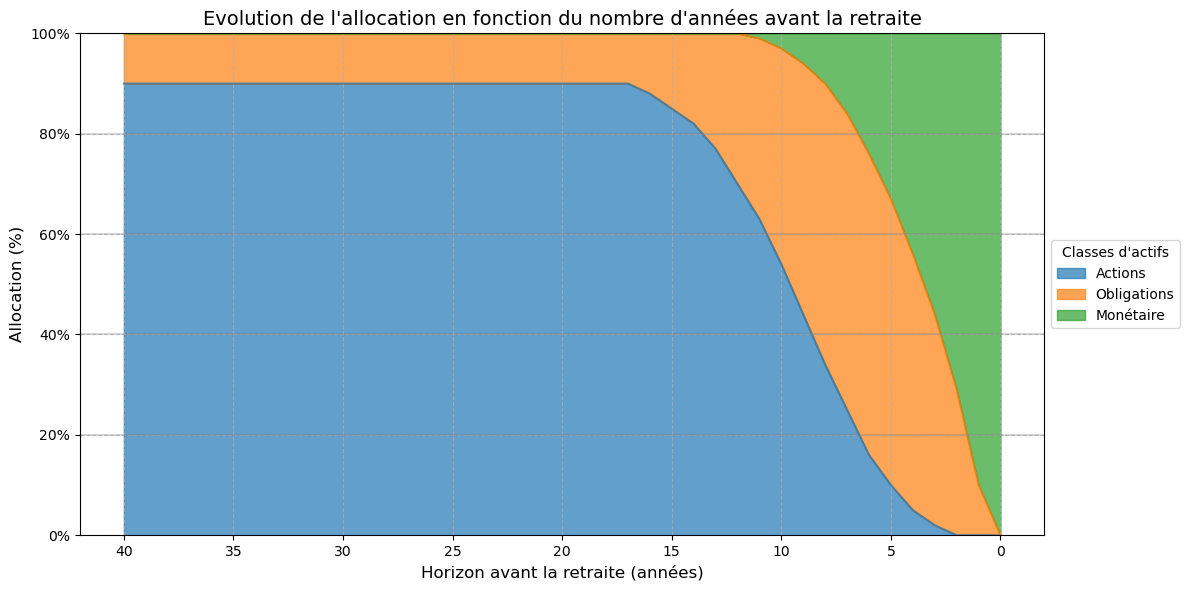

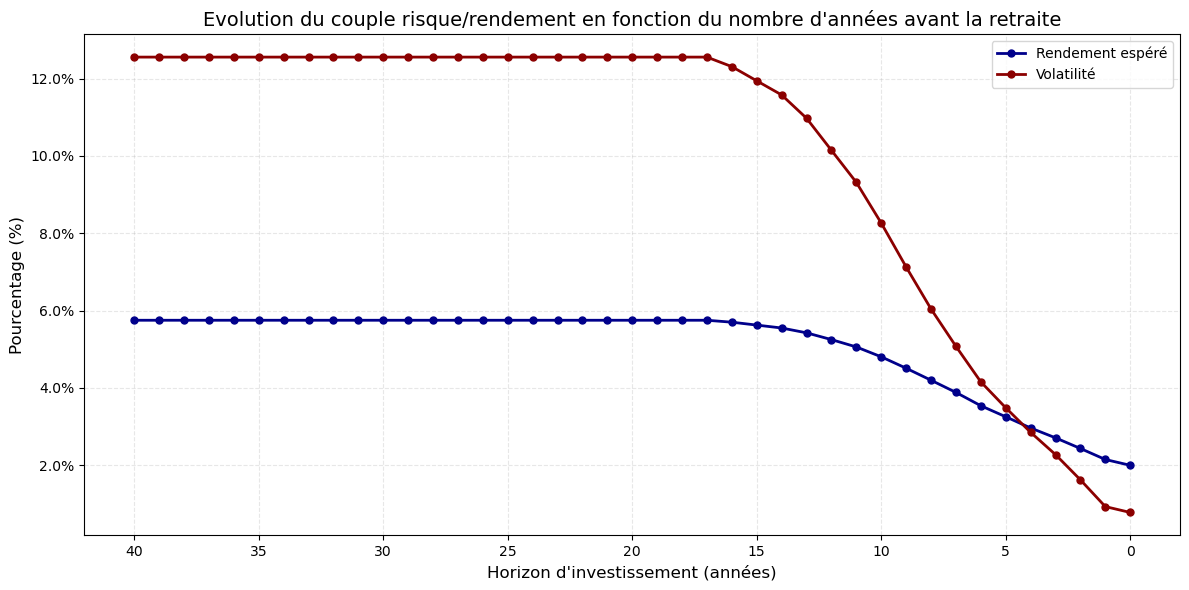

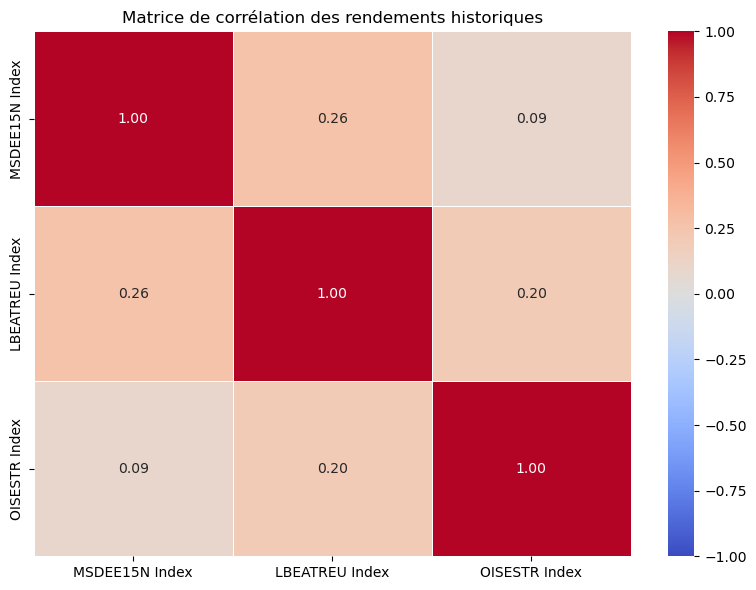

In [11]:
initial_grid.plot_weights_evolution()
initial_grid.plot_risk_return()
initial_grid.plot_correlation_heatmap(annot=True)

## Nouvelle grille équilibre

In [12]:
sheet_weights = pd.read_excel("Données.xlsx", sheet_name="Nouvelle grille équilibre")
new_weights = sheet_weights.iloc[2:,:].astype(float)
new_weights.columns = ["Horizon", *sheet_weights.iloc[1,1:].values]
new_weights = new_weights.set_index("Horizon")
new_weights.head(1)

,MSDEE15N Index,MCLDE15 Index,MLCLEEU Index,MIVLACE Index,MGILAWO Index,MGILACE Index,MIVLAWO Index,SPX Index,NKY Index,HSI Index,...,LF98TRUU Index,LMBITR Index,EMLCTRUU Index,LEGATRUU Index,BTSYTRUU Index,OISESTR Index,SPBDELB Index,NU739027 Index,B3REITP Index,DE732829 Index
Horizon,,,,,,,,,,,,,,,,,,,,,
40.0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


On prend comme hypothèse que la moyenne des rendements annuels sur 10 ans va correspondre à notre rendement à chaque date. Pour les indices présents dans la grille initale, on force l'hypothèse à 6%, 3%, 2%.

In [13]:
rdt_esperes = annual_returns.mean()
# A supp si au final on fixe pas
rdt_esperes[["MSDEE15N Index", "LBEATREU Index", "OISESTR Index" ]] = [0.06, 0.035, 0.02] 
new_hypothetical_returns = pd.DataFrame(np.tile(rdt_esperes.values.tolist(), (41, 1)), columns=new_weights.columns)
new_grid = Grid(new_weights, new_hypothetical_returns, quarterly_returns, annalization_factor=4)

In [20]:
new_hypothetical_returns

,MSDEE15N Index,MCLDE15 Index,MLCLEEU Index,MIVLACE Index,MGILAWO Index,MGILACE Index,MIVLAWO Index,SPX Index,NKY Index,HSI Index,...,LF98TRUU Index,LMBITR Index,EMLCTRUU Index,LEGATRUU Index,BTSYTRUU Index,OISESTR Index,SPBDELB Index,NU739027 Index,B3REITP Index,DE732829 Index
0,0.06,0.049662,0.024101,0.038637,0.128728,0.063892,0.059145,0.126806,0.084543,0.0155,...,0.061339,0.020884,0.032192,0.008794,0.001658,0.02,0.002272,0.108302,0.036696,0.092295
1,0.06,0.049662,0.024101,0.038637,0.128728,0.063892,0.059145,0.126806,0.084543,0.0155,...,0.061339,0.020884,0.032192,0.008794,0.001658,0.02,0.002272,0.108302,0.036696,0.092295
2,0.06,0.049662,0.024101,0.038637,0.128728,0.063892,0.059145,0.126806,0.084543,0.0155,...,0.061339,0.020884,0.032192,0.008794,0.001658,0.02,0.002272,0.108302,0.036696,0.092295
3,0.06,0.049662,0.024101,0.038637,0.128728,0.063892,0.059145,0.126806,0.084543,0.0155,...,0.061339,0.020884,0.032192,0.008794,0.001658,0.02,0.002272,0.108302,0.036696,0.092295
4,0.06,0.049662,0.024101,0.038637,0.128728,0.063892,0.059145,0.126806,0.084543,0.0155,...,0.061339,0.020884,0.032192,0.008794,0.001658,0.02,0.002272,0.108302,0.036696,0.092295
5,0.06,0.049662,0.024101,0.038637,0.128728,0.063892,0.059145,0.126806,0.084543,0.0155,...,0.061339,0.020884,0.032192,0.008794,0.001658,0.02,0.002272,0.108302,0.036696,0.092295
6,0.06,0.049662,0.024101,0.038637,0.128728,0.063892,0.059145,0.126806,0.084543,0.0155,...,0.061339,0.020884,0.032192,0.008794,0.001658,0.02,0.002272,0.108302,0.036696,0.092295
7,0.06,0.049662,0.024101,0.038637,0.128728,0.063892,0.059145,0.126806,0.084543,0.0155,...,0.061339,0.020884,0.032192,0.008794,0.001658,0.02,0.002272,0.108302,0.036696,0.092295
8,0.06,0.049662,0.024101,0.038637,0.128728,0.063892,0.059145,0.126806,0.084543,0.0155,...,0.061339,0.020884,0.032192,0.008794,0.001658,0.02,0.002272,0.108302,0.036696,0.092295
9,0.06,0.049662,0.024101,0.038637,0.128728,0.063892,0.059145,0.126806,0.084543,0.0155,...,0.061339,0.020884,0.032192,0.008794,0.001658,0.02,0.002272,0.108302,0.036696,0.092295


In [14]:
new_grid.portfolio_stats.head()

,Rendement,Variance,Volatilité
0.0,0.02000,0.000061,0.007808
1.0,0.02150,0.000087,0.009328
2.0,0.02435,0.000264,0.016245
3.0,0.02710,0.000518,0.022769
4.0,0.02965,0.000814,0.028529


<Axes: title={'center': "Matrice de corrélation des rendements de l'ensemble de l'univers considéré"}>

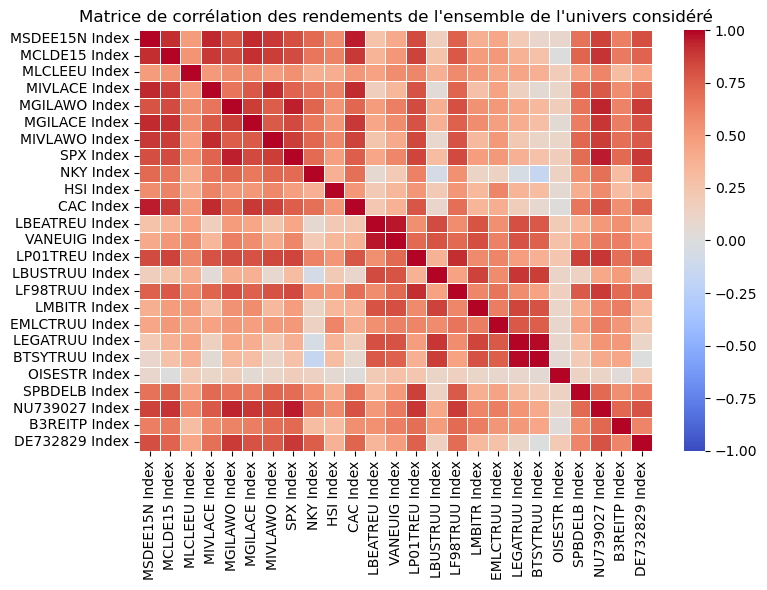

In [15]:
new_grid.plot_correlation_heatmap(title="Matrice de corrélation des rendements de l'ensemble de l'univers considéré")

In [16]:
x = new_grid.optimize_grid(initial_grid, max_gini=0.7)

c:\Users\Giovanni\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\Users\Giovanni\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
c:\Users\Giovanni\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
c:\Users\Giovanni\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
c:\Users\Giovanni\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  

L'optimisation a échoué pour l'horizon 0.0. Message: Iteration limit reached
Optimisation réussie pour 40 horizons sur 41


In [19]:
x.weights

,MSDEE15N Index,MCLDE15 Index,MLCLEEU Index,MIVLACE Index,MGILAWO Index,MGILACE Index,MIVLAWO Index,SPX Index,NKY Index,HSI Index,...,LF98TRUU Index,LMBITR Index,EMLCTRUU Index,LEGATRUU Index,BTSYTRUU Index,OISESTR Index,SPBDELB Index,NU739027 Index,B3REITP Index,DE732829 Index
Horizon,,,,,,,,,,,,,,,,,,,,,
40.0,-0.250000,-0.250000,-0.240990,-0.250000,0.560589,-0.250000,-0.250000,1.000000,-0.250000,-0.136019,...,0.978533,-0.250000,-0.084292,-0.25,-0.250000,1.0,-0.250000,0.437360,-0.250000,-0.250000
39.0,-0.250000,-0.250000,-0.240990,-0.250000,0.560589,-0.250000,-0.250000,1.000000,-0.250000,-0.136019,...,0.978533,-0.250000,-0.084292,-0.25,-0.250000,1.0,-0.250000,0.437360,-0.250000,-0.250000
38.0,-0.250000,-0.250000,-0.240990,-0.250000,0.560589,-0.250000,-0.250000,1.000000,-0.250000,-0.136019,...,0.978533,-0.250000,-0.084292,-0.25,-0.250000,1.0,-0.250000,0.437360,-0.250000,-0.250000
37.0,-0.250000,-0.250000,-0.240990,-0.250000,0.560589,-0.250000,-0.250000,1.000000,-0.250000,-0.136019,...,0.978533,-0.250000,-0.084292,-0.25,-0.250000,1.0,-0.250000,0.437360,-0.250000,-0.250000
36.0,-0.250000,-0.250000,-0.240990,-0.250000,0.560589,-0.250000,-0.250000,1.000000,-0.250000,-0.136019,...,0.978533,-0.250000,-0.084292,-0.25,-0.250000,1.0,-0.250000,0.437360,-0.250000,-0.250000
35.0,-0.250000,-0.250000,-0.240990,-0.250000,0.560589,-0.250000,-0.250000,1.000000,-0.250000,-0.136019,...,0.978533,-0.250000,-0.084292,-0.25,-0.250000,1.0,-0.250000,0.437360,-0.250000,-0.250000
34.0,-0.250000,-0.250000,-0.240990,-0.250000,0.560589,-0.250000,-0.250000,1.000000,-0.250000,-0.136019,...,0.978533,-0.250000,-0.084292,-0.25,-0.250000,1.0,-0.250000,0.437360,-0.250000,-0.250000
33.0,-0.250000,-0.250000,-0.240990,-0.250000,0.560589,-0.250000,-0.250000,1.000000,-0.250000,-0.136019,...,0.978533,-0.250000,-0.084292,-0.25,-0.250000,1.0,-0.250000,0.437360,-0.250000,-0.250000
32.0,-0.250000,-0.250000,-0.240990,-0.250000,0.560589,-0.250000,-0.250000,1.000000,-0.250000,-0.136019,...,0.978533,-0.250000,-0.084292,-0.25,-0.250000,1.0,-0.250000,0.437360,-0.250000,-0.250000


ValueError: When stacked is True, each column must be either all positive or all negative. Column 'MSDEE15N Index' contains both positive and negative values

<Figure size 1200x600 with 0 Axes>

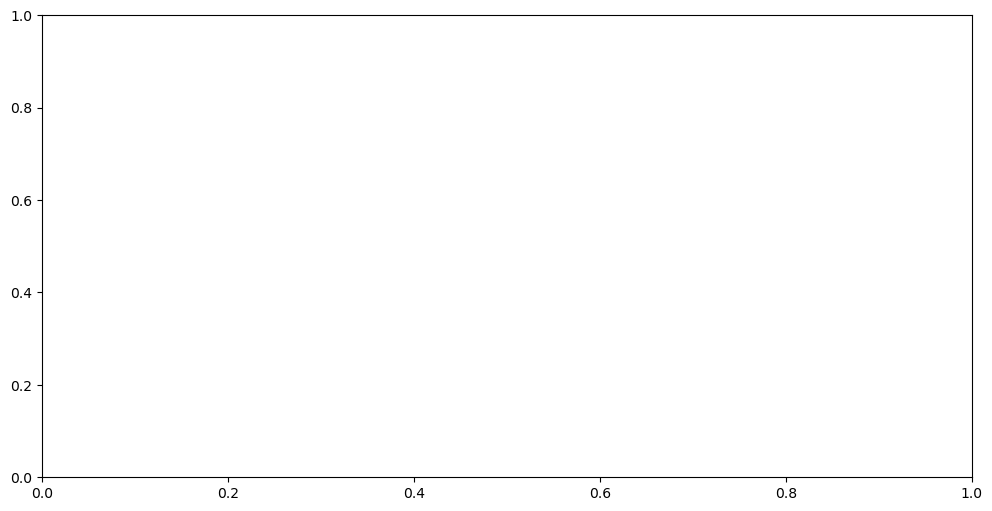

In [18]:
x.plot_weights_evolution()

In [ ]:
x.portfolio_stats.head()

,Rendement,Variance,Volatilité,Gini
0.0,0.020000,0.000061,0.007808,0.960000
1.0,0.023146,0.000087,0.009328,0.700001
2.0,0.030576,0.000264,0.016245,0.700000
3.0,0.036295,0.000518,0.022769,0.684667
4.0,0.041105,0.000814,0.028529,0.616803


In [ ]:
initial_grid.portfolio_stats.head()

,Rendement,Variance,Volatilité
0.0,0.02000,0.000061,0.007808
1.0,0.02150,0.000087,0.009328
2.0,0.02435,0.000264,0.016245
3.0,0.02710,0.000518,0.022769
4.0,0.02965,0.000814,0.028529


In [ ]:
actions = x.weights[cols_equity]
oblig = x.weights[cols_bonds]
cash = x.weights[cols_cash]
alter = x.weights[cols_alternatives]
weights_by_type = pd.concat([
    actions.sum(axis=1).rename("Equities"),
    oblig.sum(axis=1).rename("Bonds"),
    cash,
    alter.sum(axis=1).rename("Alternatives")
], axis=1)

<Figure size 1200x600 with 0 Axes>

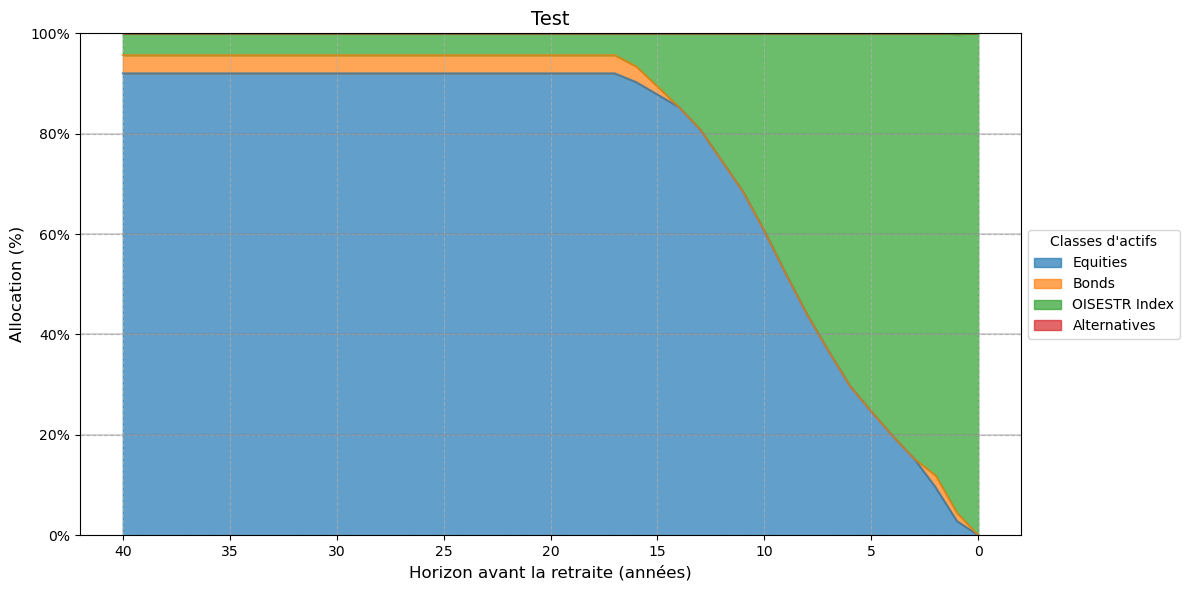

In [ ]:
plt.figure(figsize=(12, 6))

ax = weights_by_type.plot.area(figsize=(12, 6), alpha=0.7, stacked=True)

        # On inverse l'axe des abscisses, puis mettons titre, etc
ax.invert_xaxis()
ax.set_title('Test', fontsize=14)
ax.set_xlabel('Horizon avant la retraite (années)', fontsize=12)
ax.set_ylabel('Allocation (%)', fontsize=12)
ax.legend(title='Classes d\'actifs', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, 1)  
ax.grid(True, linestyle='--', alpha=0.7)

        # On ajoute une grille (tous les 20%)
for y in np.arange(0.2, 1.0, 0.2):
    ax.axhline(y=y, color='gray', linestyle='-', alpha=0.3)

        # Si les poids sont en décimales (de 0 à 1), formatez l'axe y en pourcentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

In [ ]:
comparaison = pd.DataFrame()
comparaison[["Rdt init", "Var init", "Vol init"]] = initial_grid.portfolio_stats
comparaison[["Rdt opt", "Var opt", "Vol opt", "Gini"]] = x.portfolio_stats
comparaison

,Rdt init,Var init,Vol init,Rdt opt,Var opt,Vol opt,Gini
0.0,0.02000,0.000061,0.007808,0.020000,0.000061,0.007808,0.960000
1.0,0.02150,0.000087,0.009328,0.023146,0.000087,0.009328,0.700001
2.0,0.02435,0.000264,0.016245,0.030576,0.000264,0.016245,0.700000
3.0,0.02710,0.000518,0.022769,0.036295,0.000518,0.022769,0.684667
4.0,0.02965,0.000814,0.028529,0.041105,0.000814,0.028529,0.616803
5.0,0.03255,0.001217,0.034881,0.046317,0.001217,0.034881,0.548805
6.0,0.03540,0.001729,0.041580,0.051758,0.001729,0.041580,0.483271
7.0,0.03885,0.002578,0.050772,0.059176,0.002578,0.050772,0.401811
8.0,0.04200,0.003651,0.060423,0.066928,0.003651,0.060423,0.325068
9.0,0.04510,0.005083,0.071292,0.075633,0.005083,0.071292,0.286245


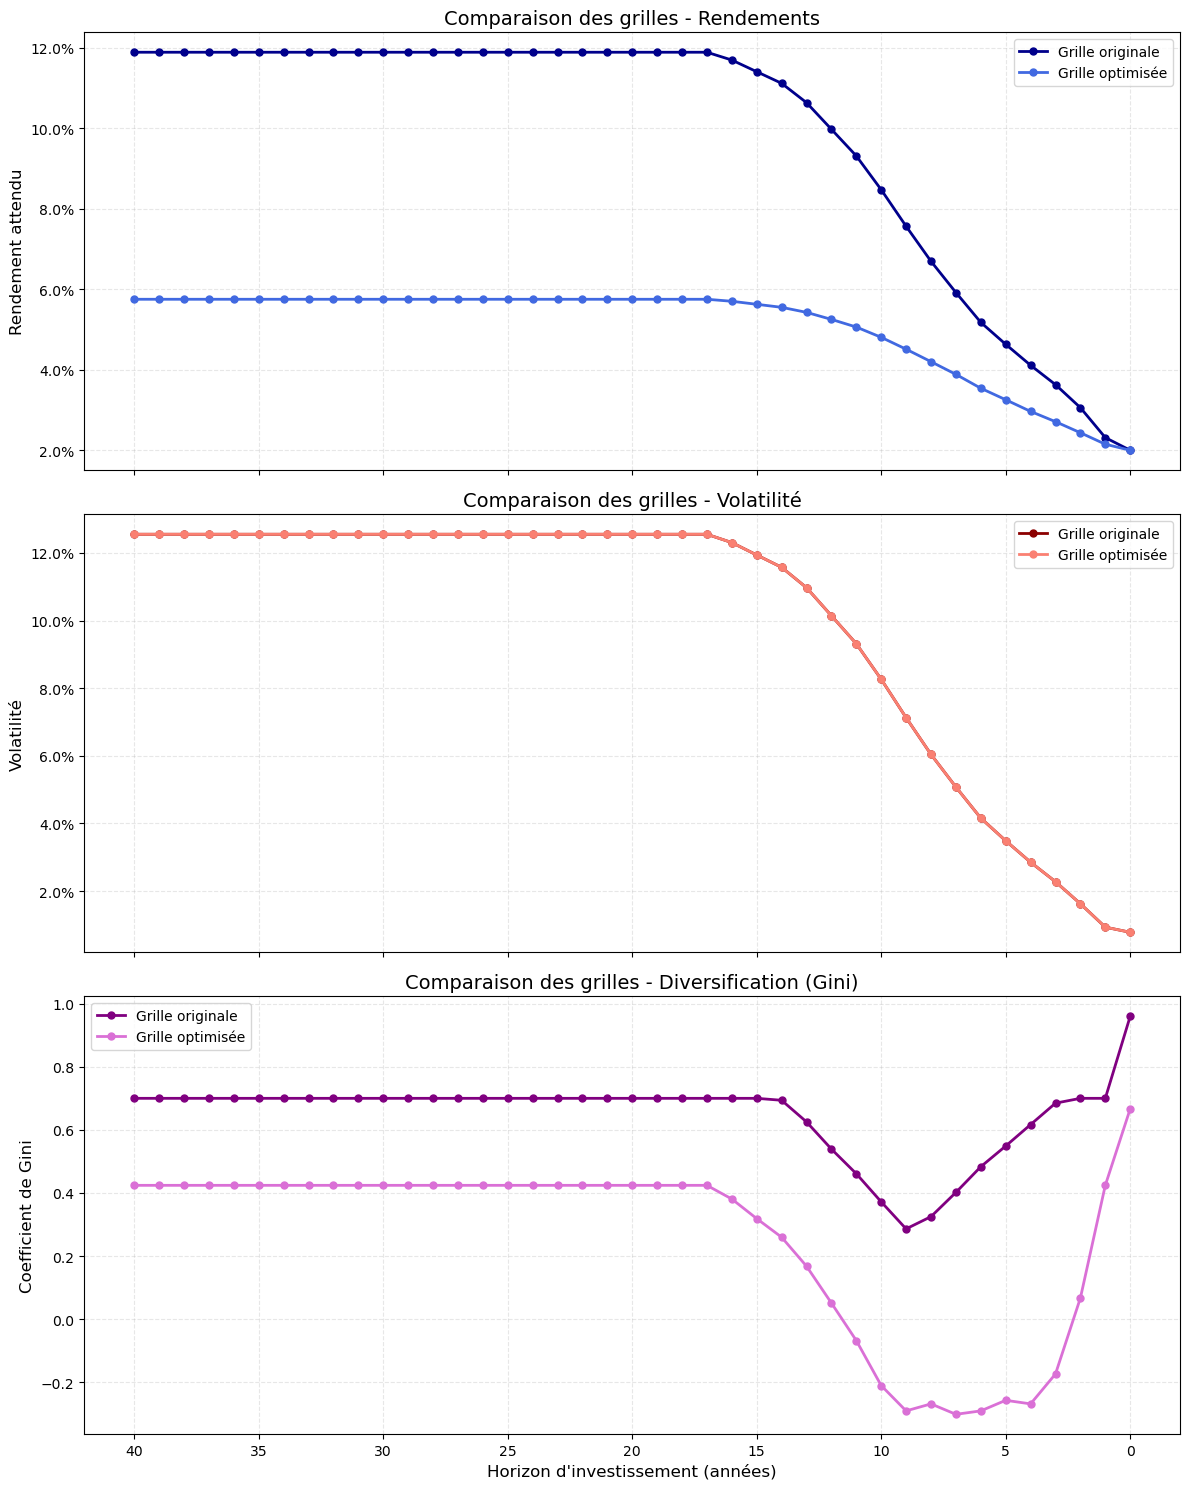

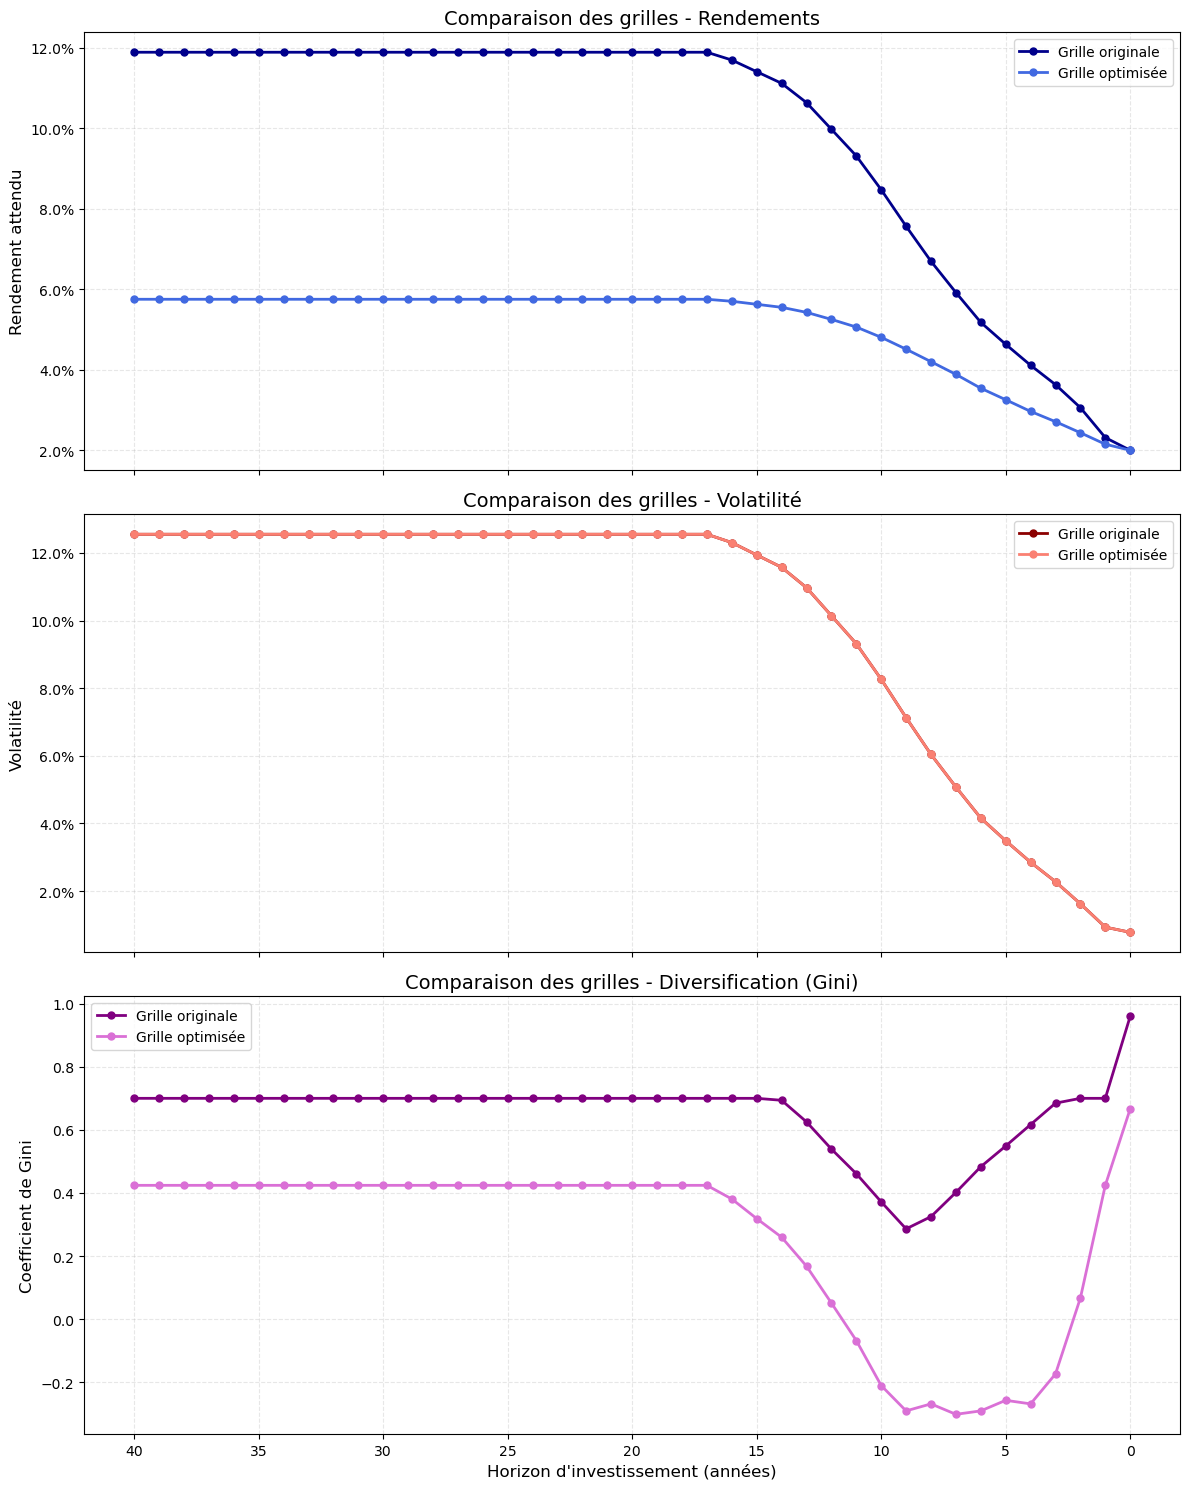

In [ ]:
x.compare_with(initial_grid)